# Objetivo

#### O objetivo deste estudo é constatar algumas estatísticas básicas sobre os nascidos vivos no Brasil de janeiro a agosto de 2024, com base nos registros do DataSUS. Informações como idade dos pais, anomalias registradas, escolaridade e estado civil das mães, tipos de partos, semanas de gestação e número de consultas pré-natal e as relações que essas variáveis podem ter entre si.

### Limpeza e tratamento de dados

In [1]:
import pandas as pd
from datetime import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Leitura dos dados

data = pd.read_csv(r'/kaggle/input/estatsticas-dos-nascidos-vivos-2024/DNOPEN24.csv', sep=";", low_memory=False)

data = data.apply(pd.to_numeric, errors='coerce')

# Conversão para int nas colunas que são float
for col in data.select_dtypes(include=['float']).columns:
    data[col] = data[col].astype('Int64', errors='ignore')

base_dados = pd.DataFrame(data)

print(base_dados.columns)

Index(['contador', 'ORIGEM', 'CODESTAB', 'CODMUNNASC', 'LOCNASC', 'IDADEMAE',
       'ESTCIVMAE', 'ESCMAE', 'CODOCUPMAE', 'QTDFILVIVO', 'QTDFILMORT',
       'CODMUNRES', 'GESTACAO', 'GRAVIDEZ', 'PARTO', 'CONSULTAS', 'DTNASC',
       'HORANASC', 'SEXO', 'APGAR1', 'APGAR5', 'RACACOR', 'PESO', 'IDANOMAL',
       'DTCADASTRO', 'CODANOMAL', 'NUMEROLOTE', 'VERSAOSIST', 'DTRECEBIM',
       'DIFDATA', 'OPORT_DN', 'DTRECORIGA', 'NATURALMAE', 'CODMUNNATU',
       'CODUFNATU', 'ESCMAE2010', 'SERIESCMAE', 'DTNASCMAE', 'RACACORMAE',
       'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'IDADEPAI', 'DTULTMENST',
       'SEMAGESTAC', 'TPMETESTIM', 'CONSPRENAT', 'MESPRENAT', 'TPAPRESENT',
       'STTRABPART', 'STCESPARTO', 'TPNASCASSI', 'TPFUNCRESP', 'TPDOCRESP',
       'DTDECLARAC', 'ESCMAEAGR1', 'STDNEPIDEM', 'STDNNOVA', 'CODPAISRES',
       'TPROBSON', 'PARIDADE', 'KOTELCHUCK'],
      dtype='object')


**Nesse estudo serão de interesse as colunas: **
* 'LOCNASC': Local de nascimento: 1 – Hospital; 2 – Outros estabelecimentos de saúde; 3- Domicílio; 4 – Outros; 5- Aldeia Indígena.
* 'IDADEMAE': Idade da mãe
* 'ESTCIVMAE': Situação conjugal da mãe: 1– Solteira; 2– Casada; 3– Viúva; 4– Separada judicialmente/divorciada; 5– União estável; 9– Ignorada
* 'ESCMAE': Escolaridade, em anos de estudo concluídos: 1 – Nenhuma; 2 – 1 a 3 anos; 3 – 4 a 7 anos; 4 – 8 a 11 anos; 5 – 12 e mais; 9 – Ignorado.
* 'PARTO': Tipo de parto: 1– Vaginal; 2–Cesáreao; 9– Ignorado
* 'CONSULTAS': Número de consultas de pré‐natal. Valores: 1– Nenhuma; 2– de 1 a 3; 3– de 4 a 6; 4– 7 e mais; 9– Ignorado
* 'DTNASC': Data de nascimento: dd mm aaaa
* 'SEXO': Sexo: 1- M – Masculino; 2- F – Feminino; 0- I – ignorado
* 'IDANOMAL': Anomalia identificada: 1– Sim; 2– Não; 9– Ignorado
* 'IDADEPAI': Idade do pai
* 'SEMAGESTAC': Número de semanas de gestaçãomero de semanas de gestação

In [3]:
# Selecionando apenas as colunas de interesse
colunas_desejadas = [
    "LOCNASC", "IDADEMAE", "ESTCIVMAE", "ESCMAE", "PARTO", 
    "CONSULTAS", "DTNASC", "SEXO", "IDANOMAL", 
    "IDADEPAI", "SEMAGESTAC"
]

base_filtrada = pd.DataFrame(base_dados)
base_filtrada = base_dados[colunas_desejadas].copy()

# Eliminando os valores NaN das colunas de datas
base_filtrada = base_filtrada.dropna(subset=['DTNASC'])

display(base_filtrada)

,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,PARTO,CONSULTAS,DTNASC,SEXO,IDANOMAL,IDADEPAI,SEMAGESTAC
0,1,24,1,3,2,2,14022024,1,2,<NA>,38
1,1,29,2,5,2,4,17042024,1,2,41,39
2,1,30,5,4,2,4,29052024,1,2,35,39
3,1,14,5,4,2,4,27052024,1,2,17,38
4,1,24,2,4,2,4,13052024,1,2,29,39
...,...,...,...,...,...,...,...,...,...,...,...
1511165,1,30,1,4,2,3,19082024,1,2,<NA>,38
1511166,1,23,1,5,1,3,20082024,1,2,<NA>,39
1511167,1,25,1,4,2,3,19082024,1,2,<NA>,39
1511168,1,20,1,5,1,4,20082024,2,2,<NA>,40


In [4]:
# Função para corrigir as datas com regex
def corrigir_datas(data):
    if pd.isna(data):  # Verifica valores ausentes
        return None
    regex = r"\b(\d{1,2})(\d{1,2})(\d{2}|\d{4})\b"
    match = re.match(regex, str(data))
    if match:
        dia, mes, ano = match.groups()
        if len(ano) == 2:  # Ajusta ano para 4 dígitos, já que a base é para o ano de 2024
            ano = "20" + ano
        return f"{dia}/{mes}/{ano}"  # Retorna no formato DD/MM/YYYY
    return None  # Retorna None para valores inválidos

# Aplicação da função na coluna DTNASC
base_filtrada['DTNASC'] = base_filtrada['DTNASC'].apply(corrigir_datas)

# Convertendo para datetime após a correção
base_filtrada['DTNASC'] = pd.to_datetime(base_filtrada['DTNASC'], format='%d/%m/%Y', errors='coerce')

# Resultado
display(base_filtrada[['DTNASC']].head())

,DTNASC
0,2024-02-14
1,2024-04-17
2,2024-05-29
3,2024-05-27
4,2024-05-13


### Mapeamento das categorias e aplicação na base de dados

In [5]:
# Criando o dicionário para substituir variáveis
mapa = {
    'LOCNASC': { 
        1: "Hospital", 2: "Outros estabelecimentos de saúde", 3: "Domicílio", 4: "Outros", 5: "Aldeia Indígena"
    },
    'ESTCIVMAE': {
        1: "Solteira", 2: "Casada", 3: "Viúva", 4: "Separada judicialmente/divorciada", 5: "União estável", 9: "Ignorada"
    },
    'ESCMAE': {
        1: "Nenhuma", 2: "1 a 3 anos", 3: "4 a 7 anos", 4: "8 a 11 anos", 5: "12 e mais", 9: "Ignorado"
    },
    'PARTO': {
        1: "Vaginal", 2: "Cesárea", 9: "Ignorado"
    },
    'CONSULTAS': {
        1: "Nenhuma", 2: "de 1 a 3", 3: "de 4 a 6", 4: "7 e mais", 9: "Ignorado"
    },
    'SEXO': {
        1: "Masculino", 2: "Feminino", 0: "Ignorado"
    },
    'IDANOMAL': {
        1: "Sim", 2: "Não", 9: "Ignorado"
    },
}

# Substituindo os valores nas colunas conforme o dicionário
for col, mapa in mapa.items():
    base_filtrada[col] = base_filtrada[col].map(mapa)

# Resultado
display(base_filtrada)

,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,PARTO,CONSULTAS,DTNASC,SEXO,IDANOMAL,IDADEPAI,SEMAGESTAC
0,Hospital,24,Solteira,4 a 7 anos,Cesárea,de 1 a 3,2024-02-14,Masculino,Não,<NA>,38
1,Hospital,29,Casada,12 e mais,Cesárea,7 e mais,2024-04-17,Masculino,Não,41,39
2,Hospital,30,União estável,8 a 11 anos,Cesárea,7 e mais,2024-05-29,Masculino,Não,35,39
3,Hospital,14,União estável,8 a 11 anos,Cesárea,7 e mais,2024-05-27,Masculino,Não,17,38
4,Hospital,24,Casada,8 a 11 anos,Cesárea,7 e mais,2024-05-13,Masculino,Não,29,39
...,...,...,...,...,...,...,...,...,...,...,...
1511165,Hospital,30,Solteira,8 a 11 anos,Cesárea,de 4 a 6,2024-08-19,Masculino,Não,<NA>,38
1511166,Hospital,23,Solteira,12 e mais,Vaginal,de 4 a 6,2024-08-20,Masculino,Não,<NA>,39
1511167,Hospital,25,Solteira,8 a 11 anos,Cesárea,de 4 a 6,2024-08-19,Masculino,Não,<NA>,39
1511168,Hospital,20,Solteira,12 e mais,Vaginal,7 e mais,2024-08-20,Feminino,Não,<NA>,40


In [6]:
# Contar NaT na coluna 'DTNASC'
quantidade_nat = base_filtrada['DTNASC'].isna().sum()
print(f"Quantidade de NaT: {quantidade_nat}")

percentual_nat = (base_filtrada['DTNASC'].isna().mean()) * 100
print(f"Percentual de NaT: {percentual_nat:.2f}%")

# Optei por eliminar os NaTs
base_filtrada = base_filtrada.dropna(subset=['DTNASC'])
display(base_filtrada)

Quantidade de NaT: 320279
Percentual de NaT: 21.19%


,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,PARTO,CONSULTAS,DTNASC,SEXO,IDANOMAL,IDADEPAI,SEMAGESTAC
0,Hospital,24,Solteira,4 a 7 anos,Cesárea,de 1 a 3,2024-02-14,Masculino,Não,<NA>,38
1,Hospital,29,Casada,12 e mais,Cesárea,7 e mais,2024-04-17,Masculino,Não,41,39
2,Hospital,30,União estável,8 a 11 anos,Cesárea,7 e mais,2024-05-29,Masculino,Não,35,39
3,Hospital,14,União estável,8 a 11 anos,Cesárea,7 e mais,2024-05-27,Masculino,Não,17,38
4,Hospital,24,Casada,8 a 11 anos,Cesárea,7 e mais,2024-05-13,Masculino,Não,29,39
...,...,...,...,...,...,...,...,...,...,...,...
1511164,Hospital,42,Solteira,12 e mais,Cesárea,7 e mais,2024-08-17,Feminino,Não,<NA>,40
1511165,Hospital,30,Solteira,8 a 11 anos,Cesárea,de 4 a 6,2024-08-19,Masculino,Não,<NA>,38
1511166,Hospital,23,Solteira,12 e mais,Vaginal,de 4 a 6,2024-08-20,Masculino,Não,<NA>,39
1511167,Hospital,25,Solteira,8 a 11 anos,Cesárea,de 4 a 6,2024-08-19,Masculino,Não,<NA>,39


In [7]:
# Transformando base_filtrada em dataframe
base_filtrada = pd.DataFrame(base_filtrada)

In [8]:
# Calculando a data mínima e máxima da base de dados
data_minima = base_filtrada['DTNASC'].min()
data_maxima = base_filtrada['DTNASC'].max()

print("Data mínima de nascimento:", data_minima)
print("Data máxima de nascimento:", data_maxima)

Data mínima de nascimento: 2024-01-10 00:00:00
Data máxima de nascimento: 2024-08-30 00:00:00


## Estatísticas básicas

### Idades das mães

In [9]:
print("Estatísticas da Idade das Mães:")
print(base_filtrada['IDADEMAE'].describe())

Estatísticas da Idade das Mães:
count    1190882.0
mean     27.758712
std        6.69628
min            8.0
25%           23.0
50%           27.0
75%           33.0
max           99.0
Name: IDADEMAE, dtype: Float64


O conjunto de dados contém alguns registros na coluna de idade das mães constando como 8 e 9 anos e 99 anos, mas como são valores um tanto quanto irreais e são poucos dados com esses valores, irei eliminar esses registros.

### Boxplot para a idade das mães

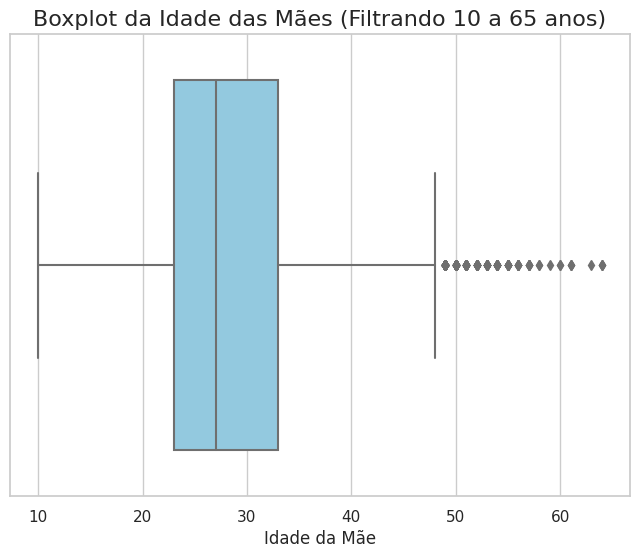

In [10]:
# Filtrando as idades das mães entre 10 e 65 anos
base_filtrada = base_filtrada[(base_filtrada['IDADEMAE'] >= 10) & (base_filtrada['IDADEMAE'] <= 65)]

# Configurando o estilo do gráfico
sns.set(style="whitegrid")

# Criando o boxplot da idade das mães
plt.figure(figsize=(8, 6))
sns.boxplot(x=base_filtrada['IDADEMAE'], color="skyblue")

# Ajustando o título e rótulos
plt.title("Boxplot da Idade das Mães (Filtrando 10 a 65 anos)", fontsize=16)
plt.xlabel("Idade da Mãe", fontsize=12)

# Exibindo o gráfico
plt.show()

#### O primeiro quartil (Q1) indica que 25% das mães possuem até aproximadamente 24 anos.
#### A mediana está em torno dos 27 anos, o que significa que metade das mães têm idade menor ou igual a este valor.
#### O terceiro quartil (Q3) está por volta dos 33 anos, indicando que 75% das mães possuem até essa idade no nascimento de seus filhos.
#### O quarto quartil (Q4) compreende as idades entre 34 e aproximadamente 48 anos, com valores acima disso sendo considerados outliers, representados pelos pontos fora dos bigodes no gráfico.

### Outliers na coluna 'Idade da Mãe'

In [11]:
# Contando quantos mães têm mais de 48 anos
maes_mais_48 = base_filtrada[base_filtrada['IDADEMAE'] > 48]

# Número total de mães na base
total_maes = base_filtrada['IDADEMAE'].count()

# Contagem e porcentagem
contagem_mais_48 = maes_mais_48['IDADEMAE'].count()
porcentagem_mais_48 = (contagem_mais_48 / total_maes) * 100

# Criando a tabela resumo
tabela_resumo = pd.DataFrame({
    'Contagem': [contagem_mais_48],
    'Porcentagem (%)': [porcentagem_mais_48]
})

print(tabela_resumo)

   Contagem  Porcentagem (%)
0       305         0.025612


Há poucos outliers na idade das mães, contando com apenas 305 registros, que representam 0.02% do conjunto de dados

### Boxplot para a idade dos pais

In [12]:
print(base_filtrada['IDADEPAI'].describe())
print(f"Registros restantes: {len(base_filtrada)}")

count     394271.0
mean     32.140857
std       7.771894
min            9.0
25%           26.0
50%           32.0
75%           37.0
max           99.0
Name: IDADEPAI, dtype: Float64
Registros restantes: 1190870


A base contém dados com idades que fogem do comum (9 e +85 anos) e não serão levadas em consideração nesse estudo, pois podem ser erros de registro ou acontecimentos muito fora da curva

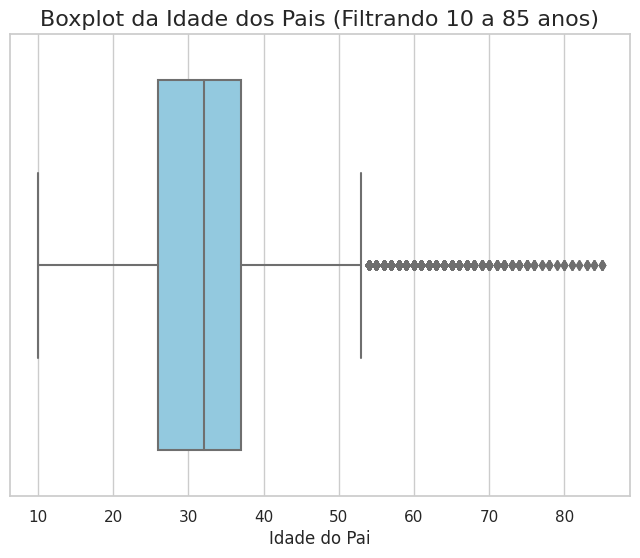

In [13]:
# Filtrando as idades dos pais entre 10 e 85 anos
base_filtrada = base_filtrada[(base_filtrada['IDADEPAI'] >= 10) & (base_filtrada['IDADEPAI'] <= 85)]

# Configurando o estilo do gráfico
sns.set(style="whitegrid")

# Criando o boxplot de idade dos pais
plt.figure(figsize=(8, 6))
sns.boxplot(x=base_filtrada['IDADEPAI'], color="skyblue")

# Ajustando o título e rótulos
plt.title("Boxplot da Idade dos Pais (Filtrando 10 a 85 anos)", fontsize=16)
plt.xlabel("Idade do Pai", fontsize=12)

# Exibindo o gráfico
plt.show()

#### O primeiro quartil (Q1) informa que até 25% dos pais possuem até 26 anos.
#### A mediana dos dados é por volta 33 anos.
#### O terceiro quartil (Q3) traz à tona que até 75% dos pais possuem aproximadamente 40 anos.
#### Os outliers aqui são bem maiores dos que as estatísticas maternas, indo de aproximadamente 52 até 85 anos.

### Há muitos outliers na questão idade dos pais?

In [14]:
# Contando quantos pais têm mais de 52 anos
pais_mais_52 = base_filtrada[base_filtrada['IDADEPAI'] > 52]

# Número total de pais na base
total_pais = base_filtrada['IDADEPAI'].count()

# Contagem e porcentagem
contagem_mais_52 = pais_mais_52['IDADEPAI'].count()
porcentagem_mais_52 = (contagem_mais_52 / total_pais) * 100

# Criando a tabela resumo
tabela_resumo = pd.DataFrame({
    'Contagem': [contagem_mais_52],
    'Porcentagem (%)': [porcentagem_mais_52]
})

print(tabela_resumo)

   Contagem  Porcentagem (%)
0      4401         1.116427


A base contém 4401 registros de pais acima de 52 anos, o que é consideravelmente maior que o número de outliers na idade das mães, representando 1.11% do total.

### Há mais anomalias registradas em nascidos de pais ou mães de mais idade?

In [15]:
# Definindo as faixas de idade
faixa_idade = ['10-30', '31-40', '41-50', '51-60', '60+']
bins = [10, 30, 40, 50, 60, float('inf')]  # Limites das faixas
labels = faixa_idade  # Etiquetas para as faixas

# Criando uma nova coluna 'faixa_idade' usando pd.cut para agrupar as idades em faixas
base_filtrada['faixa_idade_mae'] = pd.cut(base_filtrada['IDADEMAE'], bins=bins, labels=labels, right=False)
base_filtrada['faixa_idade_pai'] = pd.cut(base_filtrada['IDADEPAI'], bins=bins, labels=labels, right=False)

# Função para mapear os valores de anomalia
def mapear_anomalia(valor):
    if pd.isna(valor) or valor == 'Ignorado':
        return 0  # Ignora ou trata como 0
    return 1 if valor == 'Sim' else 0  # 'Sim' é 1, 'Não' é 0

# Contagem de anomalias por faixa de idade das mães
anomalias_por_idade_mae = base_filtrada.groupby('faixa_idade_mae', observed=False)['IDANOMAL'].agg(
    anomalias=lambda x: x.map(mapear_anomalia).sum(),  # Mapeia e soma as anomalias
    total='count'  # Conta o total de registros
).reset_index()

# Calculando a porcentagem de anomalias por faixa de idade das mães
anomalias_por_idade_mae['porcentagem_anomalias'] = (anomalias_por_idade_mae['anomalias'] / anomalias_por_idade_mae['total']) * 100

# Contagem de anomalias por faixa de idade dos pais
anomalias_por_idade_pai = base_filtrada.groupby('faixa_idade_pai', observed=False)['IDANOMAL'].agg(
    anomalias=lambda x: x.map(mapear_anomalia).sum(),  # Mapeia e soma as anomalias
    total='count'  # Conta o total de registros
).reset_index()

# Calculando a porcentagem de anomalias por faixa de idade dos pais
anomalias_por_idade_pai['porcentagem_anomalias'] = (anomalias_por_idade_pai['anomalias'] / anomalias_por_idade_pai['total']) * 100

# Exibindo as tabelas
print("Anomalias por Faixa de Idade das Mães:")
print(anomalias_por_idade_mae)

print("\nAnomalias por Faixa de Idade dos Pais:")
print(anomalias_por_idade_pai)

Anomalias por Faixa de Idade das Mães:
  faixa_idade_mae  anomalias   total  porcentagem_anomalias
0           10-30       1611  206290               0.780939
1           31-40       1553  165487               0.938442
2           41-50        373   20802               1.793097
3           51-60          2     105               1.904762
4             60+          0       1               0.000000

Anomalias por Faixa de Idade dos Pais:
  faixa_idade_pai  anomalias   total  porcentagem_anomalias
0           10-30       1202  155133               0.774819
1           31-40       1556  172182               0.903695
2           41-50        687   57395               1.196968
3           51-60         80    6848               1.168224
4             60+         14    1127               1.242236


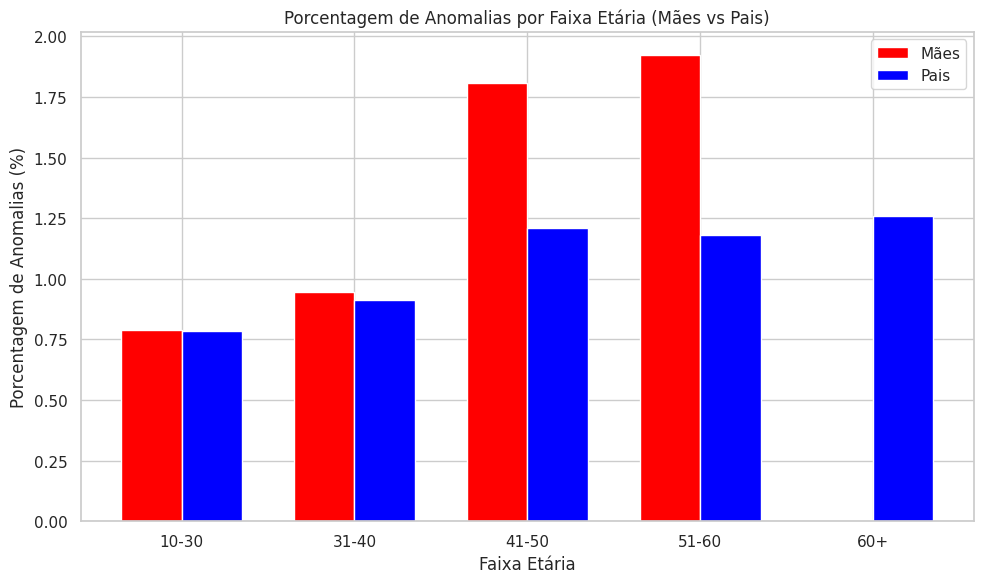

In [16]:
# Dados para o gráfico de barras
faixa_idade_mae = ['10-30', '31-40', '41-50', '51-60', '60+']
anomalias_mae = [1611, 1553, 373, 2, 0]
total_mae = [203963, 163904, 20614, 104, 1]
porcentagem_mae = [a / t * 100 for a, t in zip(anomalias_mae, total_mae)]

faixa_idade_pai = ['10-30', '31-40', '41-50', '51-60', '60+']
anomalias_pai = [1202, 1556, 687, 80, 14]
total_pai = [153350, 170474, 56867, 6785, 1110]
porcentagem_pai = [a / t * 100 for a, t in zip(anomalias_pai, total_pai)]

# Plotando o gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Criando as barras para mães e pais
bar_width = 0.35
index = range(len(faixa_idade_mae))

bar1 = ax.bar(index, porcentagem_mae, bar_width, label='Mães', color='red')
bar2 = ax.bar([i + bar_width for i in index], porcentagem_pai, bar_width, label='Pais', color='blue')

# Adicionando detalhes ao gráfico
ax.set_xlabel('Faixa Etária')
ax.set_ylabel('Porcentagem de Anomalias (%)')
ax.set_title('Porcentagem de Anomalias por Faixa Etária (Mães vs Pais)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(faixa_idade_mae)
ax.legend()

plt.tight_layout()
plt.show()

#### É possível observar que, até os 30 anos, tanto a idade dos pais quanto a das mães influenciam de forma semelhante na porcentagem de anomalias registradas. A partir dos 31 anos, a idade da mãe passa a ter um impacto maior, especialmente após os 40 anos. Por outro lado, a porcentagem de anomalias relacionada à idade dos pais se mantém praticamente constante, mesmo após os 60 anos, permanecendo em torno de 1.25%.

### Locais de nascimento e partos

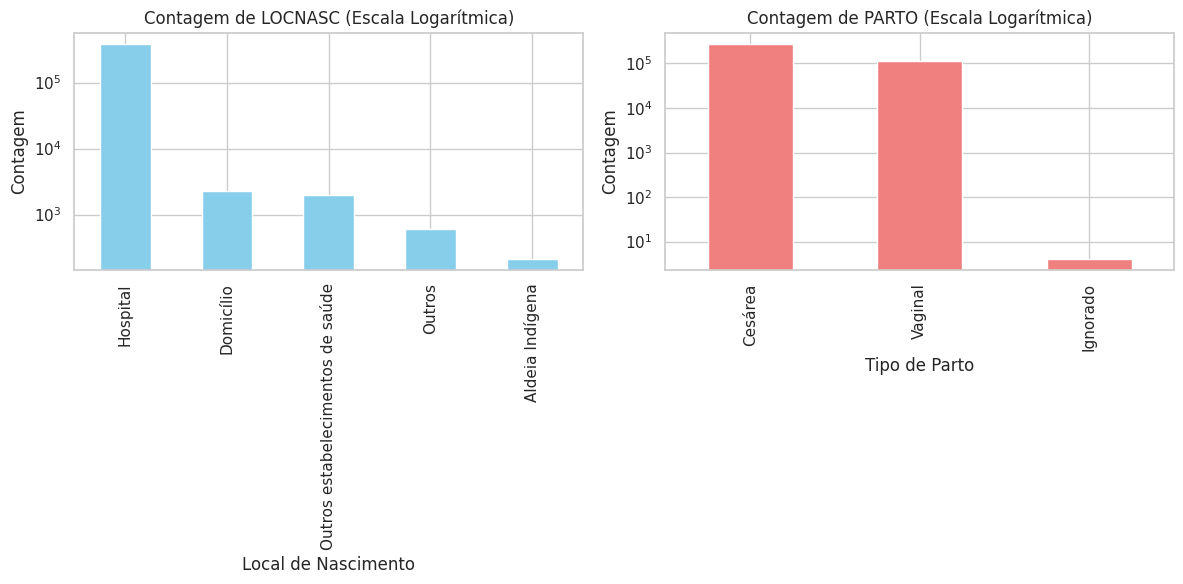

In [17]:
# Contar os valores em LOCNASC e PARTO
contagem_locnasc = base_filtrada['LOCNASC'].value_counts()
contagem_parto = base_filtrada['PARTO'].value_counts()

plt.figure(figsize=(12, 6))

# Gráfico de LOCNASC com escala logarítmica
plt.subplot(1, 2, 1)
contagem_locnasc.plot(kind='bar', color='skyblue')
plt.yscale('log')  # Aplicando escala logarítmica
plt.title('Contagem de LOCNASC (Escala Logarítmica)')
plt.xlabel('Local de Nascimento')
plt.ylabel('Contagem')

# Gráfico de PARTO com escala logarítmica
plt.subplot(1, 2, 2)
contagem_parto.plot(kind='bar', color='lightcoral')
plt.yscale('log')  # Aplicando escala logarítmica
plt.title('Contagem de PARTO (Escala Logarítmica)')
plt.xlabel('Tipo de Parto')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

#### A grande maioria dos partos tem sido realizada em hospitais, motivo pelo qual o gráfico está em escala logarítmica, o que indica que atualmente as pessoas têm mais acesso a hospitais em comparação com décadas passadas.

### Gestações normais e prematuras por tipo de parto

In [18]:
# Definindo as faixas de gestação
def classificar_gestacao(semanas):
    if pd.isna(semanas):  # Caso tenha NaN
        return 'Desconhecido'
    elif semanas <= 28:
        return 'Prematuro extremo (até 28 semanas)'
    elif 28 < semanas <= 32:
        return 'Prematuro muito precoce (28 a 32 semanas)'
    elif 32 < semanas <= 37:
        return 'Prematuro moderado a tardio (32 a 37 semanas)'
    elif 37 < semanas <= 42:
        return 'Gestação normal (37 a 42 semanas)'
    else:
        return 'Gestação a termo (+42 semanas)'

# Aplicando a função para criar a nova coluna de classificação
base_filtrada['faixa_gestacao'] = base_filtrada['SEMAGESTAC'].apply(classificar_gestacao)

# Filtrando os dados por tipo de parto (Vaginal e Cesária)
vaginal = base_filtrada[base_filtrada['PARTO'] == 'Vaginal']
cesarea = base_filtrada[base_filtrada['PARTO'] == 'Cesárea']

# Contagem e porcentagem de nascidos por faixa de gestação para parto vaginal
contagem_vaginal = vaginal.groupby('faixa_gestacao').agg(
    contagem=('SEMAGESTAC', 'count'),
    porcentagem=('SEMAGESTAC', lambda x: (x.count() / len(vaginal)) * 100)
).reset_index()

# Contagem e porcentagem de nascidos por faixa de gestação para parto cesária
contagem_cesarea = cesarea.groupby('faixa_gestacao').agg(
    contagem=('SEMAGESTAC', 'count'),
    porcentagem=('SEMAGESTAC', lambda x: (x.count() / len(cesarea)) * 100)
).reset_index()

# Tabelas
print("Contagem e Porcentagem para Parto Vaginal:")
print(contagem_vaginal)

print("\nContagem e Porcentagem para Parto Cesárea:")
print(contagem_cesarea)

Contagem e Porcentagem para Parto Vaginal:
                                  faixa_gestacao  contagem  porcentagem
0                                   Desconhecido         0     0.000000
1                 Gestação a termo (+42 semanas)       494     0.430726
2              Gestação normal (37 a 42 semanas)     87719    76.483564
3             Prematuro extremo (até 28 semanas)      1133     0.987880
4  Prematuro moderado a tardio (32 a 37 semanas)     22906    19.972099
5      Prematuro muito precoce (28 a 32 semanas)      1571     1.369779

Contagem e Porcentagem para Parto Cesárea:
                                  faixa_gestacao  contagem  porcentagem
0                                   Desconhecido         0     0.000000
1                 Gestação a termo (+42 semanas)       911     0.326250
2              Gestação normal (37 a 42 semanas)    202260    72.433873
3             Prematuro extremo (até 28 semanas)      1378     0.493493
4  Prematuro moderado a tardio (32 a 37 semanas) 

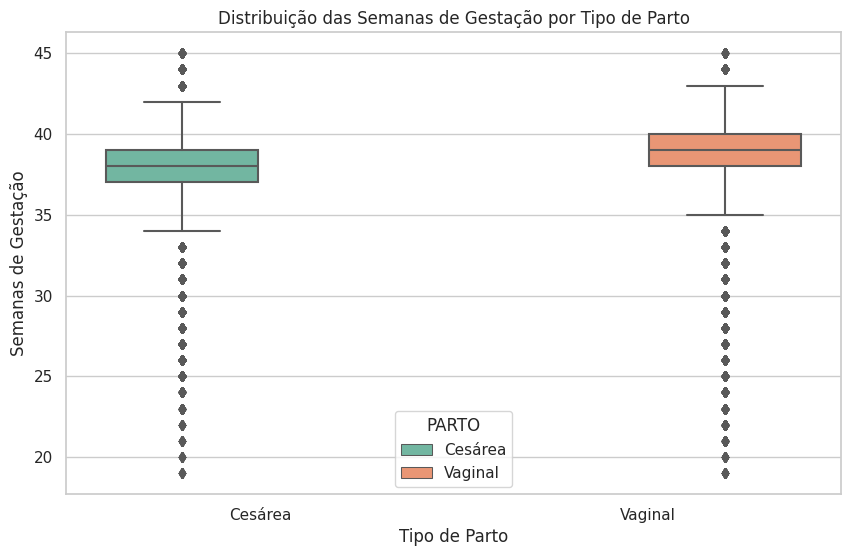

In [19]:
# Filtrando os dados para remover os valores "Ignorado" na coluna PARTO
base_filtrada_sem_ignorados = base_filtrada[base_filtrada['PARTO'] != 'Ignorado']

# Visualizando a quantidade de semanas de gestação para cada tipo de parto
plt.figure(figsize=(10, 6))

# Compração das semanas de gestação (SEMAGESTAC) entre os tipos de parto
sns.boxplot(x='PARTO', y='SEMAGESTAC', data=base_filtrada_sem_ignorados, palette="Set2", hue='PARTO')

plt.title('Distribuição das Semanas de Gestação por Tipo de Parto')
plt.xlabel('Tipo de Parto')
plt.ylabel('Semanas de Gestação')
plt.show()

#### O primeiro quartil (Q1) indica que até 25% das mulheres têm partos prematuros, geralmente por volta de 35 semanas de gestação.
#### A mediana dos dados mostra que, para partos cesáreos, a gestação ocorre por volta de 37 semanas, enquanto para partos vaginais, a mediana está em torno de 38 semanas.
#### O terceiro quartil (Q3) revela que 75% das mulheres que optam por ou necessitam de uma cesárea têm seus filhos entre 37 e 38 semanas de gestação, enquanto para partos vaginais, essa faixa é de 38 a 40 semanas.
#### O quarto quartil (Q4) informa que os 25% restantes das mulheres têm seus filhos entre 38 a 42 semanas em partos cesáreos, enquanto em partos naturais, a faixa se estende de 40 a 43 semanas.
#### Os outliers representam uma minoria, mas são mais frequentes em partos cesáreos.

### Escolaridade e estado civil das mães

In [20]:
# Definindo as faixas etárias
faixa_idade = ['10-30', '31-40', '41-50', '51-60', '60+']

# Função para categorizar a idade em faixas
def categorizar_idade(idade):
    if idade >= 10 and idade <= 30:
        return '10-30'
    elif idade >= 31 and idade <= 40:
        return '31-40'
    elif idade >= 41 and idade <= 50:
        return '41-50'
    elif idade >= 51 and idade <= 60:
        return '51-60'
    else:
        return '60+'

# Aplicando a função para categorizar a faixa de idade
base_filtrada['faixa_idade'] = base_filtrada['IDADEMAE'].apply(categorizar_idade)

# Filtrando para excluir os valores 'Ignorado'
base_filtrada_filtrada = base_filtrada[(base_filtrada['ESCMAE'] != 'Ignorado') & (base_filtrada['ESTCIVMAE'] != 'Ignorado')]

# Tabela 1: Escolaridade da mãe e faixa de idade
tabela_escolaridade_idade = base_filtrada_filtrada.groupby(['faixa_idade', 'ESCMAE']).size().reset_index(name='contagem')

# Calculando a porcentagem
tabela_escolaridade_idade['porcentagem'] = tabela_escolaridade_idade.groupby('faixa_idade')['contagem'].transform(lambda x: (x / x.sum()) * 100)

# Tabela 2: Estado civil da mãe e faixa de idade
tabela_estado_civil_idade = base_filtrada_filtrada.groupby(['faixa_idade', 'ESTCIVMAE']).size().reset_index(name='contagem')

# Calculando a porcentagem
tabela_estado_civil_idade['porcentagem'] = tabela_estado_civil_idade.groupby('faixa_idade')['contagem'].transform(lambda x: (x / x.sum()) * 100)

# Tabelas
print("Tabela de Escolaridade das Mães por Faixa de Idade:")
print(tabela_escolaridade_idade)

print("\nTabela de Estado Civil das Mães por Faixa de Idade:")
print(tabela_estado_civil_idade)

Tabela de Escolaridade das Mães por Faixa de Idade:
   faixa_idade       ESCMAE  contagem  porcentagem
0        10-30   1 a 3 anos       858     0.378012
1        10-30    12 e mais     58040    25.570873
2        10-30   4 a 7 anos     14560     6.414747
3        10-30  8 a 11 anos    153255    67.520057
4        10-30      Nenhuma       264     0.116311
5        31-40   1 a 3 anos       739     0.485807
6        31-40    12 e mais     84869    55.791557
7        31-40   4 a 7 anos      7227     4.750917
8        31-40  8 a 11 anos     59102    38.852733
9        31-40      Nenhuma       181     0.118987
10       41-50   1 a 3 anos       218     1.615653
11       41-50    12 e mais      7292    54.042837
12       41-50   4 a 7 anos       970     7.188913
13       41-50  8 a 11 anos      4965    36.796858
14       41-50      Nenhuma        48     0.355740
15       51-60   1 a 3 anos         2     2.777778
16       51-60    12 e mais        48    66.666667
17       51-60   4 a 7 anos   

### Tabela de Escolaridade das Mães por Faixa de Idade

#### Na tabela de Escolaridade das Mães por Faixa de Idade, é possível notar que uma porcentagem considerável das mães na faixa etária de 10 a 30 anos possui de 8 a 11 anos de escolaridade, o que compreende o ensino fundamental e médio. Em seguida, 25% das mães chegaram ao menos ao ensino superior ou técnico. De 7 anos de escolaridade à nenhuma escolaridade, compreendem 6,88% das mães.

#### Entre as mães de 31 a 40 anos, a escolaridade é mais elevada, com 55% delas atingindo o ensino superior ou técnico. Em segundo lugar, vem a escolaridade de 8 a 11 anos, representando quase 40% das mães. A baixa escolaridade nessa faixa é menor, representando apenas 5,21% das mãe

#### Na faixa etária de 41 a 50 anos, 54% das mães possuem 12 ou mais anos de escolaridade, e 36% delas têm entre 8 a 11 anos de escolaridade, o que é semelhante à faixa anterior. No entanto, há um salto na baixa escolaridade, representando 9% das mães com menos de 7 anos de escolaridade.
#### Entre as mães de 51 a 60 anos, observa-se um aumento significativo na porcentagem de mães com escolaridade superior a 12 anos, atingindo 66%. Enquanto 25% concluíram pelo menos o ensino fundamental ou médio, 8% possuem menos de 7 anos de escolaridade.dade.

### Tabela de Estado Civil das Mães por Faixa de Idade

#### Nas estatísticas de estado civil por faixa de idade, no grupo de 10 a 30 anos, aproximadamente 52% das mães são solteiras, seguidas por 32% de casadas e 14% em união estável.

#### Na faixa etária de 31 a 40 anos, 58% das mães são casadas, e o número de solteiras diminui para 26%, enquanto as uniões estáveis caem para 11%. Isso indica que as pessoas tendem a se casar após os 30 anos. Além disso, o número de divorciadas aumenta, de 1,06% na faixa anterior para 2,7% na faixa dos 31-40 anos.

#### Entre as mães de 41 a 50 anos, a taxa de casadas diminui para 52%, enquanto o número de divorciadas aumenta para 4,7%. As mães solteiras caem para 25%, enquanto as que estão em união estável aumentam para 12%, o que pode sugerir que algumas mulheres se separam e, em seguida, iniciam outro relacionamento.

#### Na faixa etária de 51 a 60 anos, a taxa de casadas permanece em torno de 58%, enquanto o número de divorciadas se mantém estável (cerca de 4%). As mães solteiras caem ainda mais para 15%, enquanto as uniões estáveis aumentam para 20%, representando um padrão de busca por estabilidade em relacionamentos mais tarde na vida.

#### A taxa de viúvez também aumenta com a idade, passando de 0,10% na faixa de 10-30 anos para 1,38% na faixa de 51-60 anos. anos.

### O nível de escolaridade influencia na quantidade de consultas pré-natal?

In [21]:
# Agrupando por Escolaridade e Consultas
tabela_consultas = base_filtrada.groupby(['ESCMAE', 'CONSULTAS']).size().unstack(fill_value=0)

# Calculando as porcentagens para cada grupo de escolaridade
tabela_consultas_percentual = tabela_consultas.divide(tabela_consultas.sum(axis=1), axis=0) * 100

# Resetando o índice para transformar 'ESCMAE' em coluna
tabela_consultas_percentual = tabela_consultas_percentual.reset_index()

# Reordenando as colunas
tabela_consultas_percentual = tabela_consultas_percentual[[
    'ESCMAE', 
    'de 1 a 3', 
    'de 4 a 6', 
    '7 e mais', 
    'Ignorado'
]]

# Tabela final
tabela_consultas_percentual

CONSULTAS,ESCMAE,de 1 a 3,de 4 a 6,7 e mais,Ignorado
0,1 a 3 anos,7.539901,22.014309,67.253715,0.330215
1,12 e mais,1.147421,9.383694,88.654908,0.212313
2,4 a 7 anos,6.190685,18.945518,72.772408,0.434974
3,8 a 11 anos,2.780896,13.021993,83.183951,0.230514
4,Ignorado,5.263158,15.204678,73.879142,0.584795
5,Nenhuma,16.396761,32.186235,46.153846,0.000000


#### É possível observar que no grupo com maior escolaridade (12 anos ou mais de estudo), a maioria das gestantes realizou 7 ou mais consultas pré-natal, representando 88,6%.

#### Grupos com 8 a 11 anos e 4 a 7 anos de escolaridade também apresentam altas concentrações nessa faixa de consultas, mas em níveis menores quando comparados ao grupo com maior escolaridade.

#### No grupo com nenhuma escolaridade, o maior percentual está na faixa de 7 ou mais consultas (46,1%), uma redução de 47% em relação ao grupo com maior escolaridade. Além disso, esse grupo apresenta o maior percentual (16,4%) de gestantes realizando apenas 1 a 3 consultas, o que pode indicar possíveis barreiras, como falta de acesso a serviços de saúde ou desconhecimento da importância do acompanhamento pré-natal.

## Conclusões finais

#### A maioria das mães tem idades mais jovens, com uma concentração significativa de gestantes entre 24 e 33 anos. A partir dos 31 anos, a idade das mães passa a impactar mais a ocorrência de anomalias, especialmente após os 40 anos. As mães com idades mais avançadas têm uma maior chance de anomalias, o que é esperado devido ao aumento dos riscos biológicos associados à idade gestacional.

#### A idade dos pais também impacta as anomalias, embora de maneira mais constante. Os pais mais velhos (acima dos 50 anos) representam outliers, com uma alta concentração de idades que variam entre 52 a 85 anos, um fator que pode ser relevante em análises sobre saúde paterna.

### Partos e gestações

#### A maioria dos partos ocorre em hospitais, refletindo a melhora no acesso à saúde ao longo dos anos.
#### Os partos cesáreos acontecem um pouco mais cedo (37-38 semanas), enquanto os partos vaginais tendem a ocorrer entre 38-40 semanas. Isso reflete a tendência de antecipação de partos via cesárea por razões médicas ou logísticas.
#### A maioria dos partos ocorre dentro da janela de tempo saudável (37-40 semanas), mas ainda existe uma porcentagem considerável de partos prematuros (antes de 37 semanas), especialmente para partos cesáreos.

### Escolaridade

#### Existe uma alta incidência de mães com baixa escolaridade (menos de 7 anos de estudo) nas faixas etárias mais jovens. Esse dado pode indicar uma falta de acesso a educação ou, possivelmente, um ciclo intergeracional de baixo acesso à educação.
#### Mães com 12 ou mais anos de escolaridade tendem a realizar mais consultas pré-natal e têm melhores condições para acompanhar a gestação. A escolaridade tem uma relação direta com o número de consultas, indicando a importância do acesso à educação para o cuidado gestacional.

### Estado civil

#### Na faixa etária de 10 a 30 anos, há uma maior concentração de mães solteiras. Isso diminui conforme as mulheres envelhecem, com um aumento significativo no número de mães casadas ou em união estável a partir dos 31 anos.
#### A taxa de divórcios aumenta com a idade. Isso pode indicar mudanças nas dinâmicas de relacionamento ao longo do tempo, refletindo as escolhas pessoais e as mudanças nas expectativas de vida.
#### A viúvez também aumenta com a idade, especialmente após os 50 anos, o que é esperado devido ao avanço da idade.

### Consultas pré-natal e escolaridade

#### A relação entre escolaridade e número de consultas pré-natal é clara: mães com maior escolaridade têm mais acesso e realizam mais consultas. Isso pode ser uma indicação de que a educação contribui para a conscientização sobre a importância do acompanhamento pré-natal e o acesso ao sistema de saúde.
#### Mães com nenhuma escolaridade ou baixa escolaridade (até 7 anos) têm menos consultas, com um percentual maior de gestantes realizando apenas 1 a 3 consultas. Esse dado sugere que mães em situação de vulnerabilidade educacional podem ter dificuldades para acessar cuidados médicos adequados durante a gestação, o que pode ser agravado por fatores socioeconômicos.

### Final

#### Este projeto oferece uma análise básica dos fatores que influenciam a gestação e os resultados associados a diferentes faixas etárias, escolaridade e estado civil. A análise sugere que o aumento da escolaridade, o acesso à saúde e o casamento ou união estável podem ser fatores protetores para as mães, contribuindo para melhores resultados durante a gestação. Além disso, os dados destacam a importância de abordar as desigualdades educacionais e de saúde para melhorar o acesso ao cuidado pré-natal e reduzir as disparidades nas condições de saúde materna e infantil.